In [1]:
import sys
sys.executable

'/usr/local/opt/python@3.9/bin/python3.9'

In [2]:
import os
import cv2
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Steps

## Step 1 - Segmentation

In [3]:
def process_image(image_path):
    """
    Input:   Image path (string).
    Output:  List of characters (list of ndarray of shape 257x522).
    """
    print(image_path)
    # 01 - Load the image
    img = cv2.imread(image_path)
    # 02 - Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # numpy.ndarray, (257, 522)
    # 03 - Apply thresholding to convert the image to binary
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # 04 - Perform connected component analysis to separate the characters
    connected_components_output = cv2.connectedComponentsWithStats(thresh, connectivity=8)
    # 05 - Extract characters
    chars = _process_characters(connected_components_output)
    return chars

In [4]:
def _process_characters(connected_components_output):
    num_labels, labels, stats, centroids = connected_components_output
    # Get the number of characters (excluding the background)
    num_chars = num_labels - 1
    # Define a list to store individual characters
    chars = []
    # Define a list to store the coordinates of each character
    coords = []
    # Loop through each character
    for i in range(num_chars):
        # Extract the character by cropping the image
        char = labels == i + 1
        char = char.astype(np.uint8) * 255

        # Store the character and its coordinates
        chars.append(char)
        coords.append(stats[i+1][:2])
        print(coords)
    # Sort the characters based on their x-coordinates (from right to left)
    chars = [char for _, char in sorted(zip(coords, chars), key=lambda x: x[0][0], reverse=True)]
    assert len(chars) == num_chars
    return chars

## Step 2 - Classification

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

2023-06-20 09:03:39.352302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
INPUT_IMAGE_SIZE = (32, 32, 3)


# prepare a list of image files to be loaded
def image_files(input_directory):
    filepaths = []
    labels = []

    digit_folders = os.listdir(input_directory)
    # print(digit_folders)

    for digit in digit_folders:
        path = os.path.join(input_directory, digit)
        flist = os.listdir(path)
        for f in flist:
            fpath = os.path.join(path, f)
            filepaths.append(fpath)
            labels.append(digit)
    return filepaths, labels


def load_images(filepaths):
    images = []
    for i in tqdm(range(len(filepaths))):
        img = load_img(filepaths[i], target_size=INPUT_IMAGE_SIZE, grayscale=False)
        img = img_to_array(img)
        img.astype('float32')
        img = img / 255
        images.append(img)

    images = np.array(images)
    return images

In [22]:
DATA_DIR_TRAIN = r'/Users/stav/Projects/CodeSH/vgg_for_final_project/TRAIN'
SEED           = 42
EPOCHS         = 1


def load_vgg_model():
    vgg19 = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=INPUT_IMAGE_SIZE
    )
    model = Sequential()
    model.add(vgg19)
    model.add(Flatten())
    model.add(Dense(28, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model


def train_model(model):
    # load the paths and labels in differnt variables
    filepaths, labels = image_files(DATA_DIR_TRAIN) # 5,099 files
    print(f'Using {len(filepaths):,} files for training.')
    # load the 10K images
    images = load_images(filepaths)
    y = to_categorical(labels, num_classes=28)
    X_train, X_test, y_train, y_test = train_test_split(images, y, random_state=SEED, test_size=0.2)
    print('X_train.shape:', X_train.shape)
    print('X_test.shape:',  X_test.shape)
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=128,
        validation_data=(X_test, y_test)
    )
    return history

In [10]:
model = load_vgg_model()
model.summary()

2023-06-20 09:04:01.349156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 28)                14364     
                                                                 
Total params: 20,038,748
Trainable params: 20,038,748
Non-trainable params: 0
_________________________________________________________________


### Model Training & Evaluation

In [13]:
history = train_model(model)

Using 5,104 files for training.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5104/5104 [00:03<00:00, 1322.47it/s]


X_train.shape: (4083, 32, 32, 3)
X_test.shape: (1021, 32, 32, 3)
32/32 [==============================] - 121s 4s/step - loss: 2.6063 - accuracy: 0.2630 - val_loss: 1.5598 - val_accuracy: 0.5455


In [14]:
model

In [15]:
# load the paths and labels in differnt variables
filepaths, labels = image_files(DATA_DIR_TRAIN) # 5,099 files
print(f'Using {len(filepaths):,} files for training.')
# load the 10K images
images = load_images(filepaths)
y = to_categorical(labels, num_classes=28)
X_train, X_test, y_train, y_test = train_test_split(images, y, random_state=SEED, test_size=0.2)

Using 5,104 files for training.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5104/5104 [00:03<00:00, 1514.58it/s]


In [17]:
X_train.shape, X_test.shape

((4083, 32, 32, 3), (1021, 32, 32, 3))

In [20]:
X_test[:2].shape

(2, 32, 32, 3)

In [32]:
X_test[:1].shape, type(X_test[:1])

((1, 32, 32, 3), numpy.ndarray)

In [31]:
[X_test[2].shape], type([X_test[2].shape])

([(32, 32, 3)], list)

In [36]:
np.array([X_test[2]]).shape

(1, 32, 32, 3)

In [33]:
model.predict([X_test[2]])

ValueError: in user code:

    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(32, 32, 3)


## Step 3 - Word Correction

In [ ]:
from functools import lru_cache

MIN_EDIT_DISTANCE_LENGTH = 1

def get_word_suggestions(word):
    closest_words = []
    for vocab_word in tqdm(words):
        lev_dist_word = lev_dist(word, vocab_word)
        if lev_dist_word == MIN_EDIT_DISTANCE_LENGTH:
            closest_words.append(word)
    return closest_words

def lev_dist(a, b):
    '''
    This function will calculate the levenshtein distance between two input
    strings a and b
    example: a = 'stamp', b = 'stomp', lev_dist(a,b) >> 1.0
    '''
    @lru_cache(None)  # for memorization
    def min_dist(s1, s2):

        if s1 == len(a) or s2 == len(b):
            return len(a) - s1 + len(b) - s2

        # no change required
        if a[s1] == b[s2]:
            return min_dist(s1 + 1, s2 + 1)

        return 1 + min(
            min_dist(s1, s2 + 1),      # insert character
            min_dist(s1 + 1, s2),      # delete character
            min_dist(s1 + 1, s2 + 1),  # replace character
        )

    return min_dist(0, 0)

# End2End

In [38]:
IMAGES_DIR      = '/Users/stav/Projects/CodeSH/data'
image_name_call = 'call.png'
image_path_call = os.path.join(IMAGES_DIR, image_name_call)
image_path_call

'/Users/stav/Projects/CodeSH/data/call.png'

In [32]:
def image_to_text(image_path):
    # Step 1 - Segmentation
    assert os.path.exists(image_path)
    characters = process_image(image_path)
    # Step 2 - Classification
    return characters

In [42]:
def process_image(image_path):
    """
    Input:   Image path (string).
    Output:  List of characters (list of ndarray of shape 257x522).
    """
    print(image_path)
    # 01 - Load the image
    img = cv2.imread(image_path)
    # 02 - Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # numpy.ndarray, (257, 522)
    # 03 - Apply thresholding to convert the image to binary
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # 04 - Perform connected component analysis to separate the characters
    connected_components_output = cv2.connectedComponentsWithStats(thresh, connectivity=8)
    # 05 - Extract characters
    chars = _process_characters(connected_components_output)
    return chars

In [39]:
def _process_characters(connected_components_output):
    num_labels, labels, stats, centroids = connected_components_output
    # Get the number of characters (excluding the background)
    num_chars = num_labels - 1
    # Define a list to store individual characters
    chars = []
    # Define a list to store the coordinates of each character
    coords = []
    # Loop through each character
    for i in range(num_chars):
        # Extract the character by cropping the image
        char = labels == i + 1
        char = char.astype(np.uint8) * 255

        # Store the character and its coordinates
        chars.append(char)
        coords.append(stats[i+1][:2])
        # print(coords)
    # Sort the characters based on their x-coordinates (from right to left)
    chars = [char for _, char in sorted(zip(coords, chars), key=lambda x: x[0][0], reverse=True)]
    assert len(chars) == num_chars
    return chars

In [92]:
image_path = image_path_call

In [126]:
from PIL import Image

In [109]:
print(image_path)
# 01 - Load the image
img = cv2.imread(image_path)
# 02 - Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # numpy.ndarray, (257, 522)
# 03 - Apply thresholding to convert the image to binary
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# 04 - Perform connected component analysis to separate the characters
connected_components_output = cv2.connectedComponentsWithStats(thresh, connectivity=8)
# 05 - Extract characters
# chars = _process_characters(connected_components_output)
num_labels, labels, stats, centroids = connected_components_output
# Get the number of characters (excluding the background)
num_chars = num_labels - 1
# Define a list to store individual characters
chars = []
chars_cropped = []
# Define a list to store the coordinates of each character
coords = []
# Loop through each character
for i in range(num_chars):
    # Add char
    char = labels == i + 1
    char = char.astype(np.uint8) * 255
    chars.append(char)
    # NEW - Add cropped char
    x, y, w, h, area = stats[i + 1]
    print(f'Component={i}, Original char size: {char.shape}, New char size: {char[y:y+h, x:x+w].shape}')
#     char = labels == i + 1
    char_cropped = img[y:y+h, x:x+w]
    chars_cropped.append(char_cropped)
    
    coords.append(stats[i+1][:2])
    # print(coords)
# Sort the characters based on their x-coordinates (from right to left)
#chars = [char for _, char in sorted(zip(coords, chars), key=lambda x: x[0][0], reverse=True)]

/Users/stav/Projects/CodeSH/data/call.png
Component=0, Original char size: (257, 522), New char size: (103, 2)
Component=1, Original char size: (257, 522), New char size: (37, 4)
Component=2, Original char size: (257, 522), New char size: (55, 58)
Component=3, Original char size: (257, 522), New char size: (65, 56)
Component=4, Original char size: (257, 522), New char size: (56, 46)
Component=5, Original char size: (257, 522), New char size: (39, 45)
Component=6, Original char size: (257, 522), New char size: (109, 10)
Component=7, Original char size: (257, 522), New char size: (48, 2)


In [134]:
i = 4

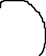

In [135]:
Image.fromarray(chars_cropped[i])

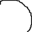

In [136]:
Image.fromarray(chars_cropped[i]).resize((32,32))

In [140]:
np.array(Image.fromarray(chars_cropped[i]).resize((32,32))).shape

(32, 32, 3)

In [142]:
np.array([np.array(Image.fromarray(chars_cropped[i]).resize((32,32)))]).shape

(1, 32, 32, 3)

In [143]:
model.predict(np.array([np.array(Image.fromarray(chars_cropped[i]).resize((32,32)))]))

1/1 [==============================] - 0s 279ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

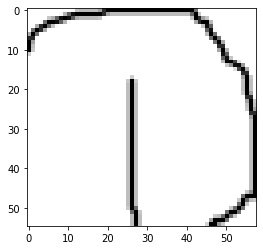

In [117]:
# for i in range(8):
i = 2
plt.imshow(chars_cropped[i])

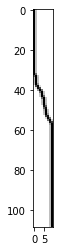

In [121]:
i = 6
plt.imshow(chars_cropped[i])

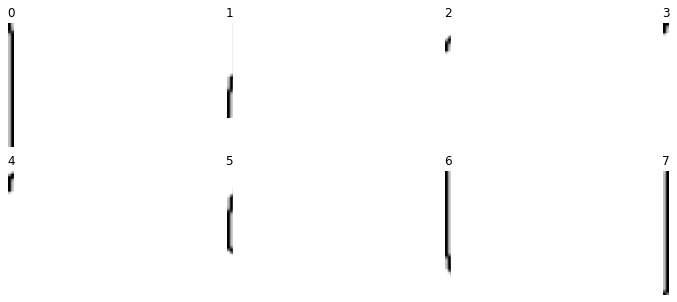

In [114]:
fig, axes = plt.subplots(2, len(chars_cropped)//2, sharex=True, sharey=True, figsize=(15, 5))

for (i, char), ax in zip(enumerate(chars_cropped), axes.flat):
    ax.imshow(char)
    ax.axis('off')
    ax.set_title(i)

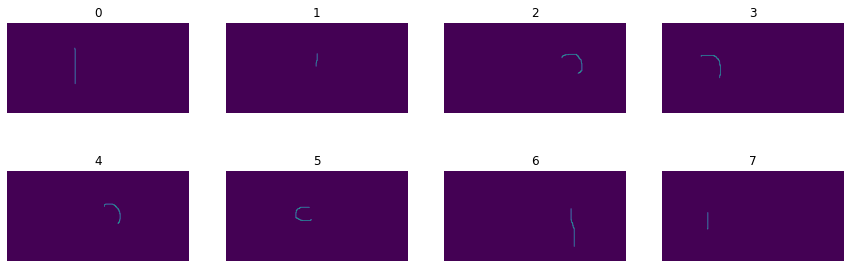

In [106]:
fig, axes = plt.subplots(2, len(chars)//2, sharex=True, sharey=True, figsize=(15, 5))

for (i, img), ax in zip(enumerate(chars), axes.flat):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(i)

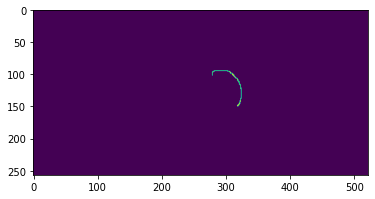

In [84]:
plt.imshow(chars[4])

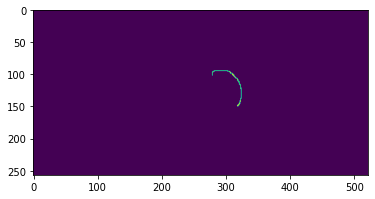

In [77]:
plt.imshow(chars[4])

In [40]:
image_path_call

'/Users/stav/Projects/CodeSH/data/call.png'

In [43]:
characters = process_image(image_path_call)

/Users/stav/Projects/CodeSH/data/call.png


In [46]:
type(characters), len(characters)

(list, 8)

In [45]:
type(characters[0]), characters[0].shape

(numpy.ndarray, (257, 522))

In [53]:
for i in range(8):
    print(type(characters[i]), characters[i].shape)

<class 'numpy.ndarray'> (257, 522)
<class 'numpy.ndarray'> (257, 522)
<class 'numpy.ndarray'> (257, 522)
<class 'numpy.ndarray'> (257, 522)
<class 'numpy.ndarray'> (257, 522)
<class 'numpy.ndarray'> (257, 522)
<class 'numpy.ndarray'> (257, 522)
<class 'numpy.ndarray'> (257, 522)


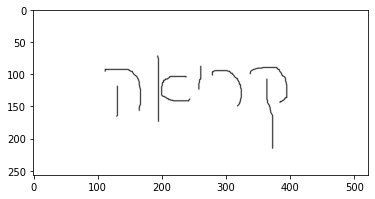

In [47]:
plt.imshow(cv2.imread(image_path_call));

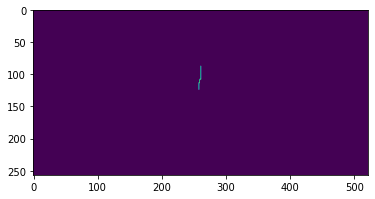

In [55]:
plt.imshow(characters[3]);

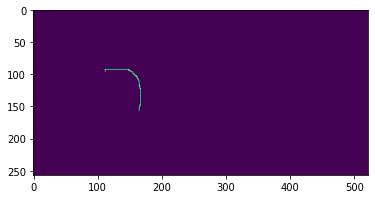

In [49]:
plt.imshow(characters[-1])

In [ ]:
characters[0].shape

In [38]:
image_path = "/Users/stav/Projects/CodeSH/data/call.png"

In [56]:
# 01 - Load the image
img = cv2.imread(image_path)
# 02 - Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # numpy.ndarray, (257, 522)
# 03 - Apply thresholding to convert the image to binary
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# 04 - Perform connected component analysis to separate the characters
connected_components_output = cv2.connectedComponentsWithStats(thresh, connectivity=8)
# 05 - Extract characters
# chars = _process_characters(connected_components_output)
num_labels, labels, stats, centroids = connected_components_output
# Get the number of characters (excluding the background)
num_chars = num_labels - 1
# Define a list to store individual characters
chars = []
chars_cropped = []
# Define a list to store the coordinates of each character
coords = []
# Loop through each character
for i in range(num_chars):
    # Extract the character by cropping the image
    char = labels == i + 1
    char = char.astype(np.uint8) * 255
    # print(labels.shape)
    # Store the character and its coordinates
    # print('char.shape:', char.shape)
    (x, y, w, h, area) = stats[i]
    print(f'(x={x}, y={y}, w={w}, h={h}, area={area})')
    # Extract the character by cropping the image
    char_cropped = img[y:y+h, x:x+w]
    chars_cropped.append(char_cropped)
    chars.append(char)
    coords.append(stats[i+1][:2])
    # print('coor:', stats[i+1][:2])
    print('char.shape:', char.shape, 'coor:', coords[-1])
# Sort the characters based on their x-coordinates (from right to left)
# chars = [char for _, char in sorted(zip(coords, chars), key=lambda x: x[0][0], reverse=True)]

(x=0, y=0, w=522, h=257, area=133295)
char.shape: (257, 522) coor: [194  71]
(x=194, y=71, w=2, h=103, area=104)
char.shape: (257, 522) coor: [258  87]
(x=258, y=87, w=4, h=37, area=40)
char.shape: (257, 522) coor: [338  89]
(x=338, y=89, w=58, h=55, area=147)
char.shape: (257, 522) coor: [112  92]
(x=112, y=92, w=56, h=65, area=133)
char.shape: (257, 522) coor: [279  94]
(x=279, y=94, w=46, h=56, area=126)
char.shape: (257, 522) coor: [200 103]
(x=200, y=103, w=45, h=39, area=136)
char.shape: (257, 522) coor: [364 107]
(x=364, y=107, w=10, h=109, area=123)
char.shape: (257, 522) coor: [130 118]


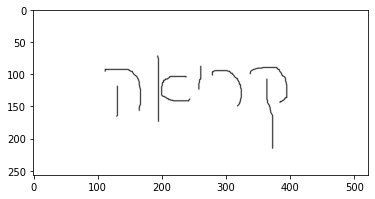

In [54]:
plt.imshow(cv2.imread(image_path_call));

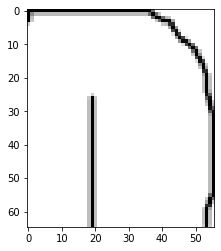

In [64]:
plt.imshow(chars_cropped[4])

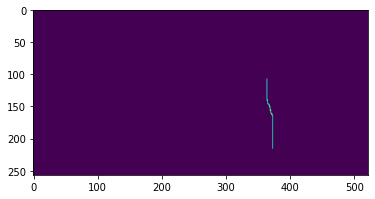

In [42]:
plt.imshow(chars[0])

In [ ]:
# img = img_to_array(characters[0]).astype('float32') / 255

In [ ]:
model.predict(images[0])

In [1]:
WORDS_FILENAME = "all_append_fatverb.txt"

In [23]:
words = open(WORDS_FILENAME).read().splitlines()

In [24]:
print(f'Number of words: {len(words):,}')

Number of words: 469,509


In [65]:
for _ in range(5):
    print(random.choice(words))

צלופחי
נערכי
תהגני
מכחישתן
עירויו


In [ ]:
אאביק

In [66]:
indices = [28872, 186472, 306417, 316132]
print(', '.join([words[idx] for idx in indices]))

בינה, מלאכותית, שלום, תודה


In [67]:
'שלום' in words, 'שלים' in words

(True, True)